In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.lines import Line2D 
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
from matplotlib import rc
from obspy.imaging.beachball import beachball
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from obspy.imaging.beachball import beach
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.io.img_tiles import StamenTerrain
from cartopy.io.img_tiles import GoogleTiles
from owslib.wmts import WebMapTileService

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
%matplotlib inline

<h1> Geographic Plotting: Focal Mechanisms <h1>

<h2> Introduction </h2>

<p> In geophysics, a focal mechanism is a way of visualizing how a given fault geometry slipped when an earthquake occurred. The focal mechanism, also known as a beachball, is parameterized by three angular quantities given by the  <b>strike</b>, defined as the azimuthal angle measured clockwise from north, the <b>dip</b>, defined as the angle at which the fault is measured downward from the horizontal, and the <b>rake</b>, which is the angle in which the fault moves relative to the azimuth when an event occurs. These angles are inferred from seismic data and then are plotted using a stereographic projection, as shown below. </p>

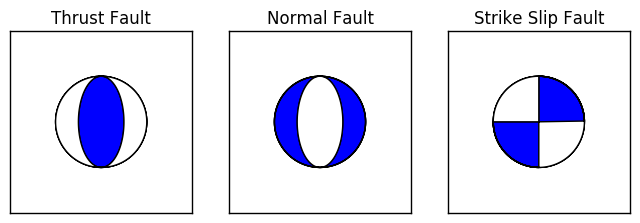

In [32]:
plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0, 0])
b = beach([0, 45, 90], xy=(0, 0), width=1, linewidth=1, facecolor = 'blue')
ax.add_collection(b)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Thrust Fault')
ax.set_aspect('equal')

ax1 = plt.subplot(gs[0, 1])
b1 = beach([0, 45, -90], xy=(0, 0), width=1, linewidth=1, facecolor = 'blue')
ax1.add_collection(b1)
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(r'Normal Fault')
ax1.set_aspect('equal')

ax2 = plt.subplot(gs[0, 2])
b2 = beach([0, 90, 0], xy=(0, 0), width=1, linewidth=1, facecolor = 'blue')
ax2.add_collection(b2)
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title(r'Strike Slip Fault')
ax2.set_aspect('equal')

<p> A focal mechanism is useful for visualizing fault geometries but also can be used as a proxy for determining the direction of the stresses (the forces that caused an earthquake) acted on the fault. The shaded region indicates where the fault felt tensional stresses and the non-shaded region indicates where the fault felt compressional stresses. The solid lines separating the two regions indicate possible fault planes. We are unable to fully resolve how the fault moved during an event because the earthquake was caused by a double couple set of forces and the motion is not directly measured, rather inferred by seismic data. Two fault plane solutions, called nodal planes, are possible given a single event. </p>

<p> Using the interactive widget below, we can visualize how focal mechanisms change as different values for the strike, dip, and rake are given. </p>

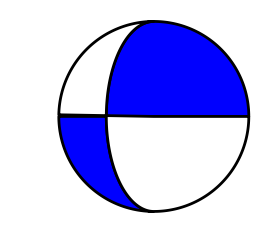

In [33]:
def f(strike,dip,rake):
    
    mt2 = [strike, dip, rake]
    beachball(mt2, size=200, linewidth=2, facecolor='b')
    
    return 
interact(f, strike = (0, 360), dip = (0, 90), rake = (-180, 180))
plt.show()

<h2> Context </h2>

<p> Focal mechanisms can be used as proxy measurements for the underlying stresses that caused an earthquake. If different focal mechanisms observed in the same region we are able to infer information regarding the underlying stress field of a given region, which has applications to earthquake hazards and predictions. Ideally, we want to invert multiple focal mechanisms for the underlying stresses but right now we will only focus on gaining a qualitative understanding of the stress field near Istanbul by plotting focal mechansisms for earthquakes leading up tothe devasting 1999 Izmut earthquake.

<h2> Methods </h2>

<p> We will create a geographic plot of grouped focal mechanisms using cartopy, obspy, and matplotlib. The focal mechanisms were grouped using a hierarchial classifcation algorithm where the similarity matrix was dependent on distance between events and the fault type of each event. </p>

<p> We begin by uploading the data using pandas and storing the headers as a numpy array. </p>

In [34]:
focs = pd.read_csv('TestFocalMechanisms.csv')
headers = focs.columns.values
focs.head()

,latitude,longitude,depth,strike,dip,rake,strike error,dip error,strike-dip correlation,rake error,rake-strike correlation,rake-dip correlation,magnitude,group
0,40.83,28.24,15.0,355,70,-11,10,10,0,10,0,0,5.3,3
1,40.82,27.77,12.0,33,42,-137,10,10,0,10,0,0,4.5,1
2,40.86,27.67,12.0,92,46,-137,10,10,0,10,0,0,5.0,1
3,40.80,27.84,12.0,20,70,133,10,10,0,10,0,0,4.5,1
4,40.60,29.04,0.0,175,70,-20,10,10,0,10,0,0,2.1,6


<p> We are interested in creating a focal mechanism using the strike, dip, and rake, and then creating a map of the region where the focal mechanisms are plotted by their location and colored in terms of the group they belong to.

<p> Next let's create the map using cartopy. We can query an image from a website using cartopys web map tile serice. We will be using the next generation blue marble image provided by NASA. <p>

In [35]:
#Specify image URL
URL = 'http://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(URL)

#Specify image to use
layers = ['BlueMarble_NextGeneration']

#Specify date corresponding to image
date_str = '2017-02-12'


<p> Next we specify the type of projection and the desired coordinate system </p>

In [36]:
plot_CRS = ccrs.Mercator()
geodetic_CRS = ccrs.Geodetic()

<p> First we specify the limits of the map, in latitude and longitude, and then use <b>plot_CRS.transform_point()</b> to transform the data into the new geodetic coordinate system used for plotting. </p>

In [37]:
# 0 corresponds to min 1 corresponds to max
lat0 = 40
lat1 = 42
lon0 = 27
lon1 = 31

x0, y0 = plot_CRS.transform_point(lon0, lat0, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(lon1, lat1, geodetic_CRS)

<p> We then create the figure by adding the map using <b>ax.add_wmts()</b>

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=150)
ax = plt.axes([0, 0, 1, 1], projection=plot_CRS)
ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))
ax.add_wmts(wmts, layers[0], wmts_kwargs={'time': date_str})
ist_lat, ist_lon = 41.0082,28.9784


<p> We can create the beachballs using obspy's <b>beach()</b> command. It's important to note that when plotting the beachballs we have to transform the latitude and longitude coordinates of the event to the plotting coordinate system which can be again done using the <b>plot_CRS.transform_point()</b> command</p>

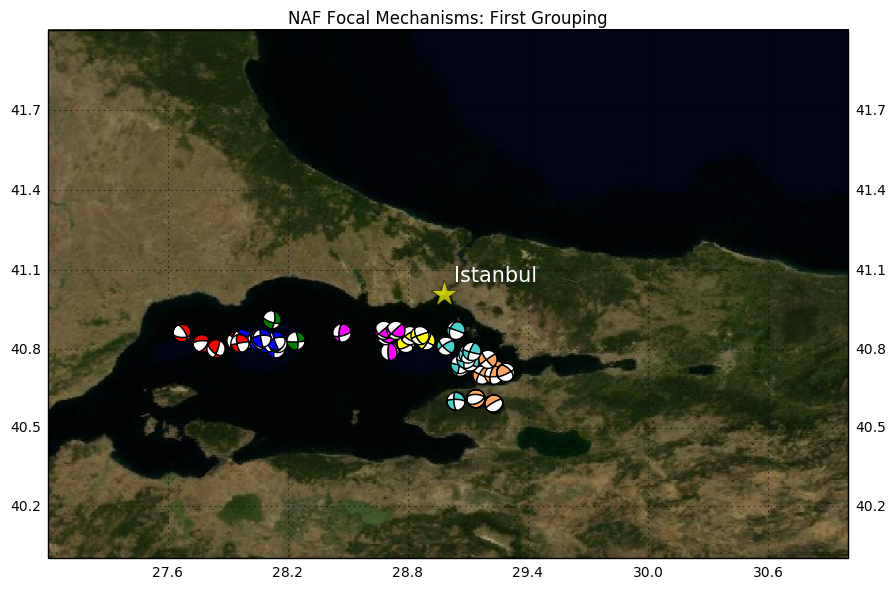

In [41]:
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.axes([0, 0, 1, 1], projection=plot_CRS)
ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))
ax.add_wmts(wmts, layers[0], wmts_kwargs={'time': date_str})
ist_lat, ist_lon = 41.0082,28.9784
ax.plot(ist_lon, ist_lat, marker='*', color='yellow', markersize=20, alpha=0.7, transform=ccrs.Geodetic())


colors = ['red', 'blue', 'green', 'magenta', 'yellow', 'mediumturquoise', 'sandybrown']

for eq_num in range(len(focs[headers[-1]])):
    nodal_planes = np.array([focs[headers[3]][eq_num], focs[headers[4]][eq_num], focs[headers[5]][eq_num]])
    lon = focs[headers[1]][eq_num]
    lat = focs[headers[0]][eq_num]
    group = focs[headers[-1]][eq_num]-1
    lx, ly = plot_CRS.transform_point(lon, lat, geodetic_CRS)
    b = beach(nodal_planes, xy=(lx, ly), width=10100, linewidth=1, facecolor = colors[group])
    b.set_zorder(1000)
    ax.add_collection(b)
    
gl = ax.gridlines( draw_labels=True)

# suppress gridline labels at top to allow space for title
gl.xlabels_top = False
ax.text(ist_lon+0.05, ist_lat+0.05, r'Istanbul', fontsize=15, transform=ccrs.Geodetic(), color = 'white')
ax.set_title('NAF Focal Mechanisms: First Grouping')

plt.savefig('NAF_FM_1st_Grouping.png')
plt.show()